In [1220]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

In [1221]:
data = yf.download("SPY", start="2000-01-01", end="2023-12-31")

[*********************100%***********************]  1 of 1 completed


In [1222]:
data.columns = data.columns.get_level_values(0)
data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

<Axes: xlabel='Date'>

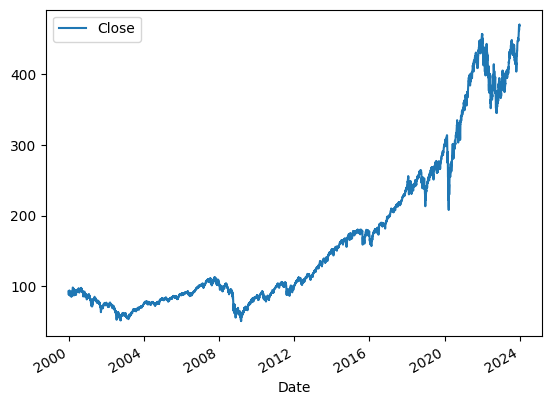

In [1223]:
data.plot.line(y="Close", use_index=True)

In [1224]:
data["% Change"] = (data["Close"] - data["Close"].shift(1)) / data["Close"].shift(1)
data["Target"] = (data["% Change"].shift(-1) > 0).astype(int)

data["10-Day MA"] = data["Close"].rolling(window=10).mean()
data["50-Day MA"] = data["Close"].rolling(window=50).mean()
data["200-Day MA"] = data["Close"].rolling(window=200).mean()

data["Rel_MA_Diff_10_50"] = (data["10-Day MA"] - data["50-Day MA"]) / data["Close"]
data["Rel_MA_Diff_50_200"] = (data["50-Day MA"] - data["200-Day MA"]) / data["Close"]

data["Price_Dist_10"] = (data["Close"] - data["10-Day MA"]) / data["Close"]
data["Price_Dist_50"] = (data["Close"] - data["50-Day MA"]) / data["Close"]
data["Price_Dist_200"] = (data["Close"] - data["200-Day MA"]) / data["Close"]

data["Crossover_10_50"] = (data["10-Day MA"] > data["50-Day MA"]).astype(int)
data["Crossover_50_200"] = (data["50-Day MA"] > data["200-Day MA"]).astype(int)

delta = data["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=2).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=2).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))
data["RSI"] = rsi
data["RSI_Signal"] = 0  # Initialize to 0
data.loc[data["RSI"] > 90, "RSI_Signal"] = -1  # RSI > 70: -1 (negative signal)
data.loc[data["RSI"] < 10, "RSI_Signal"] = 1

data.dropna(inplace=True)


In [1225]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    pred = model.predict_proba(test[predictors])[:, 1]
    threshold = 0.4
    pred[pred >= threshold] = 1
    pred[pred < threshold] = 0
    pred = pd.Series(pred, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], pred], axis=1)
    return combined

In [1226]:
def backtest(data, predictors, model, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [1227]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

predictors = ["% Change", "Rel_MA_Diff_10_50", "Rel_MA_Diff_50_200", "Price_Dist_10", "Price_Dist_50", "Price_Dist_200", "Crossover_10_50", "Crossover_50_200", "RSI_Signal"]#, "Volume", "SMA_10", "SMA_50", "EMA_10", "EMA_50", "RSI", "High_Low", "High_Close", "Low_Close", "True_Range", "ATR"]
preds = backtest(data, predictors, model)

In [1228]:
preds["% Change"] = data["% Change"]
preds["Cumulative Return"] = (1 + preds["% Change"]).cumprod().copy()
preds["RSI_Signal"] = data["RSI_Signal"]
preds["Value"] = (10000 * preds["Cumulative Return"])
preds["Crossover_10_50"] = data["Crossover_10_50"]
preds["Crossover_50_200"] = data["Crossover_50_200"]

In [1229]:
# Count growth and decline days
count_growth = (preds["Target"] == 1).sum()
count_decline = (preds["Target"] == 0).sum()

print(f"Days of Growth: {count_growth}")
print(f"Days of Decline: {count_decline}")

# True/False Positives and Negatives for RSI_Signal
true_positive_rsi = ((preds["Target"] == 1) & (preds["RSI_Signal"] == 1)).sum()
true_negative_rsi = ((preds["Target"] == 0) & (preds["RSI_Signal"] == -1)).sum()
false_positive_rsi = ((preds["Target"] == 0) & (preds["RSI_Signal"] == 1)).sum()
false_negative_rsi = ((preds["Target"] == 1) & (preds["RSI_Signal"] == -1)).sum()

# True/False Positives and Negatives for Crossover_10_50
true_positive_crossover_10_50 = ((preds["Target"] == 1) & (preds["Crossover_10_50"] == 1)).sum()
true_negative_crossover_10_50 = ((preds["Target"] == 0) & (preds["Crossover_10_50"] == 0)).sum()
false_positive_crossover_10_50 = ((preds["Target"] == 0) & (preds["Crossover_10_50"] == 1)).sum()
false_negative_crossover_10_50 = ((preds["Target"] == 1) & (preds["Crossover_10_50"] == 0)).sum()

# True/False Positives and Negatives for Crossover_50_200
true_positive_crossover_50_200 = ((preds["Target"] == 1) & (preds["Crossover_50_200"] == 1)).sum()
true_negative_crossover_50_200 = ((preds["Target"] == 0) & (preds["Crossover_50_200"] == 0)).sum()
false_positive_crossover_50_200 = ((preds["Target"] == 0) & (preds["Crossover_50_200"] == 1)).sum()
false_negative_crossover_50_200 = ((preds["Target"] == 1) & (preds["Crossover_50_200"] == 0)).sum()

# True/False Positives and Negatives for Predictions
true_positive_predictions = ((preds["Target"] == 1) & (preds["Predictions"] == 1)).sum()
true_negative_predictions = ((preds["Target"] == 0) & (preds["Predictions"] == 0)).sum()
false_positive_predictions = ((preds["Target"] == 0) & (preds["Predictions"] == 1)).sum()
false_negative_predictions = ((preds["Target"] == 1) & (preds["Predictions"] == 0)).sum()

# Count total crossovers and predictions
count_crossover_10_50 = (preds["Crossover_10_50"] == 1).sum()
count_crossover_50_200 = (preds["Crossover_50_200"] == 1).sum()
count_predictions = (preds["Predictions"] == 1).sum()

# Print values in an organized manner
print("\nSummary of Metrics")
print("-" * 30)
print("RSI_Signal:")
print(f"  True Positives: {true_positive_rsi}")
print(f"  True Negatives: {true_negative_rsi}")
print(f"  False Positives: {false_positive_rsi}")
print(f"  False Negatives: {false_negative_rsi}")

print("\nCrossover_10_50:")
print(f"  True Positives: {true_positive_crossover_10_50}")
print(f"  True Negatives: {true_negative_crossover_10_50}")
print(f"  False Positives: {false_positive_crossover_10_50}")
print(f"  False Negatives: {false_negative_crossover_10_50}")
print(f"  Total Crossovers: {count_crossover_10_50}")

print("\nCrossover_50_200:")
print(f"  True Positives: {true_positive_crossover_50_200}")
print(f"  True Negatives: {true_negative_crossover_50_200}")
print(f"  False Positives: {false_positive_crossover_50_200}")
print(f"  False Negatives: {false_negative_crossover_50_200}")
print(f"  Total Crossovers: {count_crossover_50_200}")

print("\nPredictions:")
print(f"  True Positives: {true_positive_predictions}")
print(f"  True Negatives: {true_negative_predictions}")
print(f"  False Positives: {false_positive_predictions}")
print(f"  False Negatives: {false_negative_predictions}")
print(f"  Total Predictions: {count_predictions}")

# Balance calculations
balance_10_50 = 10000
balance_50_200 = 10000
balance_predictions = 10000
balance_cross_rsi = 10000
real_balance = 10000

for i in range(len(preds) - 1):
    # Update balance for Crossover_10_50
    if preds["Crossover_10_50"].iloc[i] == 1:
        balance_10_50 = balance_10_50 * (1 + preds["% Change"].iloc[i + 1])

    # Update balance for Crossover_50_200
    if preds["Crossover_50_200"].iloc[i] == 1:
        balance_50_200 = balance_50_200 * (1 + preds["% Change"].iloc[i + 1])

    # Update balance for Predictions
    if preds["Predictions"].iloc[i] == 1:
        balance_predictions = balance_predictions * (1 + preds["% Change"].iloc[i + 1])
    
    if (preds["Crossover_10_50"].iloc[i] == 1) & (preds["RSI_Signal"] == 1):
        balance_cross_rsi = balance_cross_rsi * (1 + preds["% Change"].iloc[i + 1])

    # Update real balance
    real_balance = real_balance * (1 + preds["% Change"].iloc[i + 1])

print("\nPortfolio Balances:")
print("-" * 30)
print(f"Balance with Crossover_10_50: {balance_10_50:.2f}")
print(f"Balance with Crossover_50_200: {balance_50_200:.2f}")
print(f"Balance with Predictions: {balance_predictions:.2f}")
print(f"Real Balance: {real_balance:.2f}")


Days of Growth: 1838
Days of Decline: 1500

Summary of Metrics
------------------------------
RSI_Signal:
  True Positives: 437
  True Negatives: 532
  False Positives: 343
  False Negatives: 619

Crossover_10_50:
  True Positives: 1323
  True Negatives: 408
  False Positives: 1092
  False Negatives: 515
  Total Crossovers: 2415

Crossover_50_200:
  True Positives: 1517
  True Negatives: 284
  False Positives: 1216
  False Negatives: 321
  Total Crossovers: 2733

Predictions:
  True Positives: 1818
  True Negatives: 18
  False Positives: 1482
  False Negatives: 20
  Total Predictions: 3300

Portfolio Balances:
------------------------------
Balance with Crossover_10_50: 25368.59
Balance with Crossover_50_200: 31366.67
Balance with Predictions: 53418.24
Real Balance: 53340.52


In [1230]:
# Calculate true positives, true negatives, false positives, and false negatives
true_positive = ((preds["Crossover_10_50"] == 1) & 
                 (preds["RSI_Signal"] == 1) & 
                 (preds["Target"] == 1)).sum()

true_negative = ((preds["Crossover_10_50"] == 0) & 
                 (preds["RSI_Signal"] == -1) & 
                 (preds["Target"] == 0)).sum()

false_positive = ((preds["Crossover_10_50"] == 1) & 
                  (preds["RSI_Signal"] == 1) & 
                  (preds["Target"] == 0)).sum()

false_negative = ((preds["Crossover_10_50"] == 0) & 
                  (preds["RSI_Signal"] == -1) & 
                  (preds["Target"] == 1)).sum()

# Print results
print("Metrics for Combined Conditions (Crossover_10_50 and RSI_Signal):")
print("-" * 50)
print(f"  True Positives: {true_positive}")
print(f"  True Negatives: {true_negative}")
print(f"  False Positives: {false_positive}")
print(f"  False Negatives: {false_negative}")




Metrics for Combined Conditions (Crossover_10_50 and RSI_Signal):
--------------------------------------------------
  True Positives: 310
  True Negatives: 140
  False Positives: 230
  False Negatives: 177
